In [1]:
# Install Library
!pip install pandas-ta

In [3]:
# Impor Library
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import pandas_ta as ta

### Data Extraction

In [4]:
#load dataset
start_date = (datetime.now() - relativedelta(years=3)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

df = yf.download("CAT", start=start_date, end=end_date)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df_ori = df.copy()
df.head()

/tmp/ipython-input-1297265356.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("CAT", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2022-12-23,227.905777,228.542357,224.703870,225.131422,1959900
2022-12-27,231.012695,232.827432,227.763279,228.684899,3381500
2022-12-28,227.440216,231.658760,226.395076,231.012670,2270000
2022-12-29,228.219330,229.559005,226.385601,229.178962,1652500
2022-12-30,227.611221,228.181300,225.843994,227.449702,1521100


### Backtesting Performance

In [6]:
#Define the functions for each strategy
def get_signal_rsi_bband(close, max_hold_days=10, min_rsi=30,
                         max_rsi=40, length_rsi=10, length_sma=200,
                         length_bband=20):
    """
    Pass in a time series of closing price, optional maximum holding days,
    minimum and the maximum rsi (relative strength index) for entering and exiting,
    the window for calculating the rsi, the length for the simple moving average,
    the length for calculating the bollinger bands, returns the buying and selling dates.
    RSI + Bollinger bands trading strategy:
    - Entry: 10-period RSI below 30, the price is above the 200-day moving average,
    and the price is above the upper Bollinger band (buy on the nex day's open).
    - Exit: 10-period RSI above 40 or after 10 trading days (sell on the next day's open).
    """
    buy_date = []
    sell_date = []

    # Make sure that it has enough data
    if (len(close) > length_sma+max_hold_days+1):
        # Calculate RSI and the standard moving average
        df = pd.DataFrame({'Close': close})
        df['RSI'] = ta.rsi(df['Close'], length=length_rsi)
        df['SMA'] = ta.sma(df['Close'], length=length_sma)
        # Calculate the Bollinger bands
        bband = ta.bbands(df['Close'], length=length_bband)
        df['Low BBAND'] = bband.iloc[:,0]
        df['Up BBAND'] = bband.iloc[:,2]
        # Replace None with NaN
        df = df.fillna(value=np.nan)
        # Drop NaN values
        df = df.dropna()

        # Get the buying signal using RSI strategy
        df['Buy RSI'] = np.where((df['Close'] > df['SMA']) &
                                 (df['RSI'] < min_rsi), True, False)

        # Get the buying and selling signals using BBAND strategy
        df['Buy BBAND'] = np.where(df['Close'] < df['Low BBAND'],
                                   True, False)

        # Get the buying and selling dates
        for i in range(len(df['Buy RSI']) - (max_hold_days+1)):
            if (df['Buy RSI'].iloc[i] == True &
                df['Buy BBAND'].iloc[i] == True):
                # Buy tomorrow
                buy_date.append(df['Buy RSI'].index[i+1])
                # Sell if the maximum holding day has been reached or
                # RSI is above max_rsi on the next day
                for j in range(1,max_hold_days+1):
                    if df['RSI'].iloc[i+j] > max_rsi :
                        sell_date.append(df['Buy RSI'].index[i+j+1])
                        break
                    elif j == max_hold_days:
                        sell_date.append(df['Buy RSI'].index[i+j+1])

    # Avoid overlapping position
    df2 = pd.DataFrame({'buy date':buy_date, 'sell date':sell_date})
    no_ovlp = df2[df2['buy date'] > df2['sell date'].shift(1)]
    # Add the first trade
    no_ovlp = pd.concat([df2[:1], no_ovlp])
    return no_ovlp['buy date'], no_ovlp['sell date']

df = df_ori.copy()
buy_date, sell_date = get_signal_rsi_bband(df['Close'])

df.ta.bbands(length=20, append=True)
df.dropna(inplace=True)
df.tail(5)

Price,Close,High,Low,Open,Volume,BBL_20_2.0_2.0,BBM_20_2.0_2.0,BBU_20_2.0_2.0,BBB_20_2.0_2.0,BBP_20_2.0_2.0
Date,,,,,,,,,,
2025-12-16,588.929993,598.659973,586.280029,590.700012,2319400,535.479473,581.249493,627.019514,15.748838,0.583903
2025-12-17,561.890015,591.000000,557.460022,587.590027,3753300,538.150940,581.999994,625.849048,15.068404,0.270691
2025-12-18,565.830017,574.659973,561.909973,568.500000,2193000,540.205226,582.635995,625.066765,14.565104,0.301960
2025-12-19,576.219971,581.729980,570.330017,572.690002,5355600,545.166910,584.140494,623.114077,13.343908,0.398386
2025-12-22,582.409973,585.789978,575.690002,584.489990,2233100,550.108557,585.739493,621.370428,12.166137,0.453278


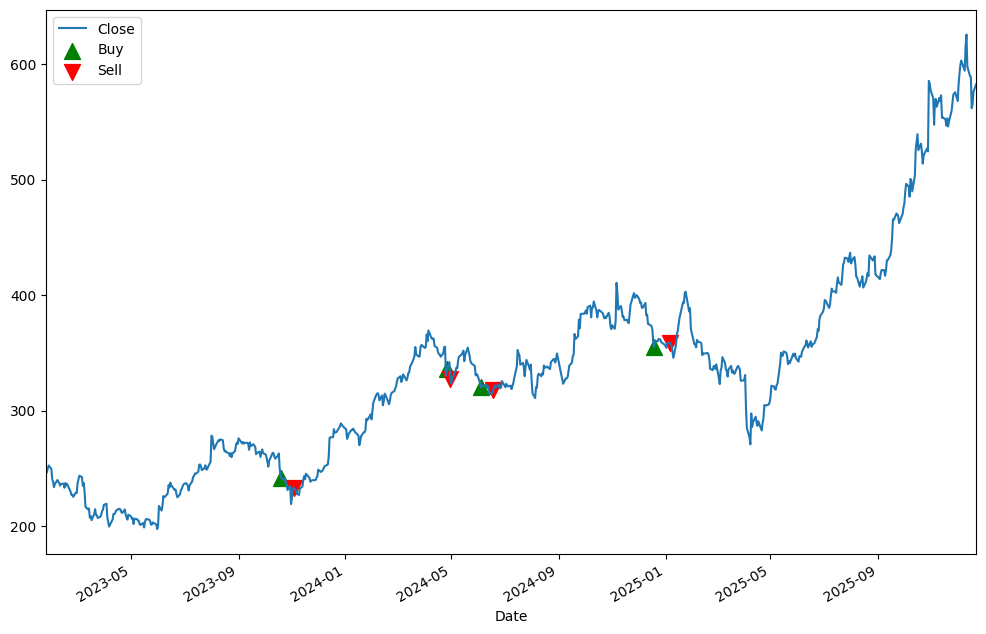

In [7]:
#Visualize RSI BBAND Strategies
ax = df['Close'].plot(figsize=(12,8))
ax.scatter(buy_date, df.loc[buy_date].Close, marker='^', c='g', s=130, label='Buy')
ax.scatter(sell_date, df.loc[sell_date].Close, marker='v', c='r', s=130, label='Sell');
ax.autoscale(tight=True, axis='x');
ax.legend()
ax.grid;

In [8]:
#Calculate the profit
buy_sell = pd.DataFrame({'Buy': df.loc[buy_date,'Open'],
                         'Sell': df.loc[sell_date,'Open']})
buy_sell.tail(5)

,Buy,Sell
Date,,
2024-04-30,NaN,339.252105
2024-06-04,321.351954,NaN
2024-06-18,NaN,315.818665
2024-12-19,362.958927,NaN
2025-01-06,NaN,361.540378


In [9]:
buy_sell['Sell'] = buy_sell['Sell'].shift(-1)
buy_sell.dropna(inplace=True)

profit = (buy_sell.Sell - buy_sell.Buy)/buy_sell.Buy
win = [i for i in profit if i > 0]
pct_win = 100*len(win)/(len(profit)+1e-6)
print(f'Winning percentage: {np.round(pct_win, 2)}%')
print(f'Mean profit: {np.round(np.mean(profit*100), 2)}%')
print(f'Number of transactions: {len(profit)}')

Winning percentage: 25.0%
Mean profit: -0.87%
Number of transactions: 4


In [10]:
# Store the average holding period
hold_day = []
for buy, sell in zip(buy_date, sell_date):
    hold_day.append(sell - buy)
print(f'Mean holding period: {np.mean(hold_day)}')

Mean holding period: 12 days 12:00:00
